This notebook takes a Gaia-style catalogue and performs clustering in integral of motion space according to Lövdal et al. (2022).

Requires some libraries, most notably vaex, numpy, scipy and matplotlib. After changing the variable "catalogue_path" to indicate where your star catalogue is stored, you should be able to run the cells in order, and obtain a catalogue containing labels for significant clusters in integral of motion space.

The input catalogue should contain heliocentric xyz coordinates and xyz velocity components, where necessary quality cuts has been readily imposed. The input should contain halo stars and a little bit more, as we use vtoomre>180 when scrambling velocity components to obtain an artificial reference representation of a halo.

In [55]:
import numpy as np
import sys,glob,os,time
import vaex, vaex.ml, vaex.ml.cluster
import importdata, cluster_utils, plotting_utils

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%config IPCompleter.use_jedi = False
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

from importlib import reload
from tqdm.notebook import tqdm
reload(importdata)
reload(cluster_utils)
reload(plotting_utils)
np.random.seed(0)

In [30]:
'''
PARAMETERS
'''

N_datasets = 100 #Number of artificial datasets generated
linkage_method='single' #Linkage method for clustering
N_sigma_significance = 2 #Criterion for statistical significance of a cluster

features = ['scaled_En', 'scaled_Lperp', 'scaled_Lz'] #Clustering features
features_to_be_scaled = ['En', 'Lperp', 'Lz'] #Clustering features that need scaling
minmax_values = vaex.from_arrays(En=[-170000, 0], Lperp=[0, 4300], Lz=[-4500,4600]) #Fix origin for scaling of features

N_sigma_ellipse_axis = 2.83 #Length (in standard deviations) of axis of ellipsoidal cluster boundary
min_members = 10 #Smallest cluster size that we are interested in checking
max_members = 100000 #Largest cluster size that we are interested in checking.
                     #This was not imposed in the paper but can be set for improved computational efficiency

catalogue_path = '../raw_data/gaia_example_vtoomre180.hdf5' #Path to raw data
result_path = '../Results/' #Path to folder where intermediate and final results are stored

INFO:MainThread:matplotlib.mathtext:Substituting symbol \perp from STIXGeneral
INFO:MainThread:matplotlib.mathtext:Substituting symbol \perp from STIXGeneral
INFO:MainThread:matplotlib.mathtext:Substituting symbol \perp from STIXGeneral
INFO:MainThread:matplotlib.mathtext:Substituting symbol \perp from STIXGeneral
INFO:MainThread:matplotlib.mathtext:Substituting symbol \perp from STIXGeneral
INFO:MainThread:matplotlib.mathtext:Substituting symbol \perp from STIXGeneral


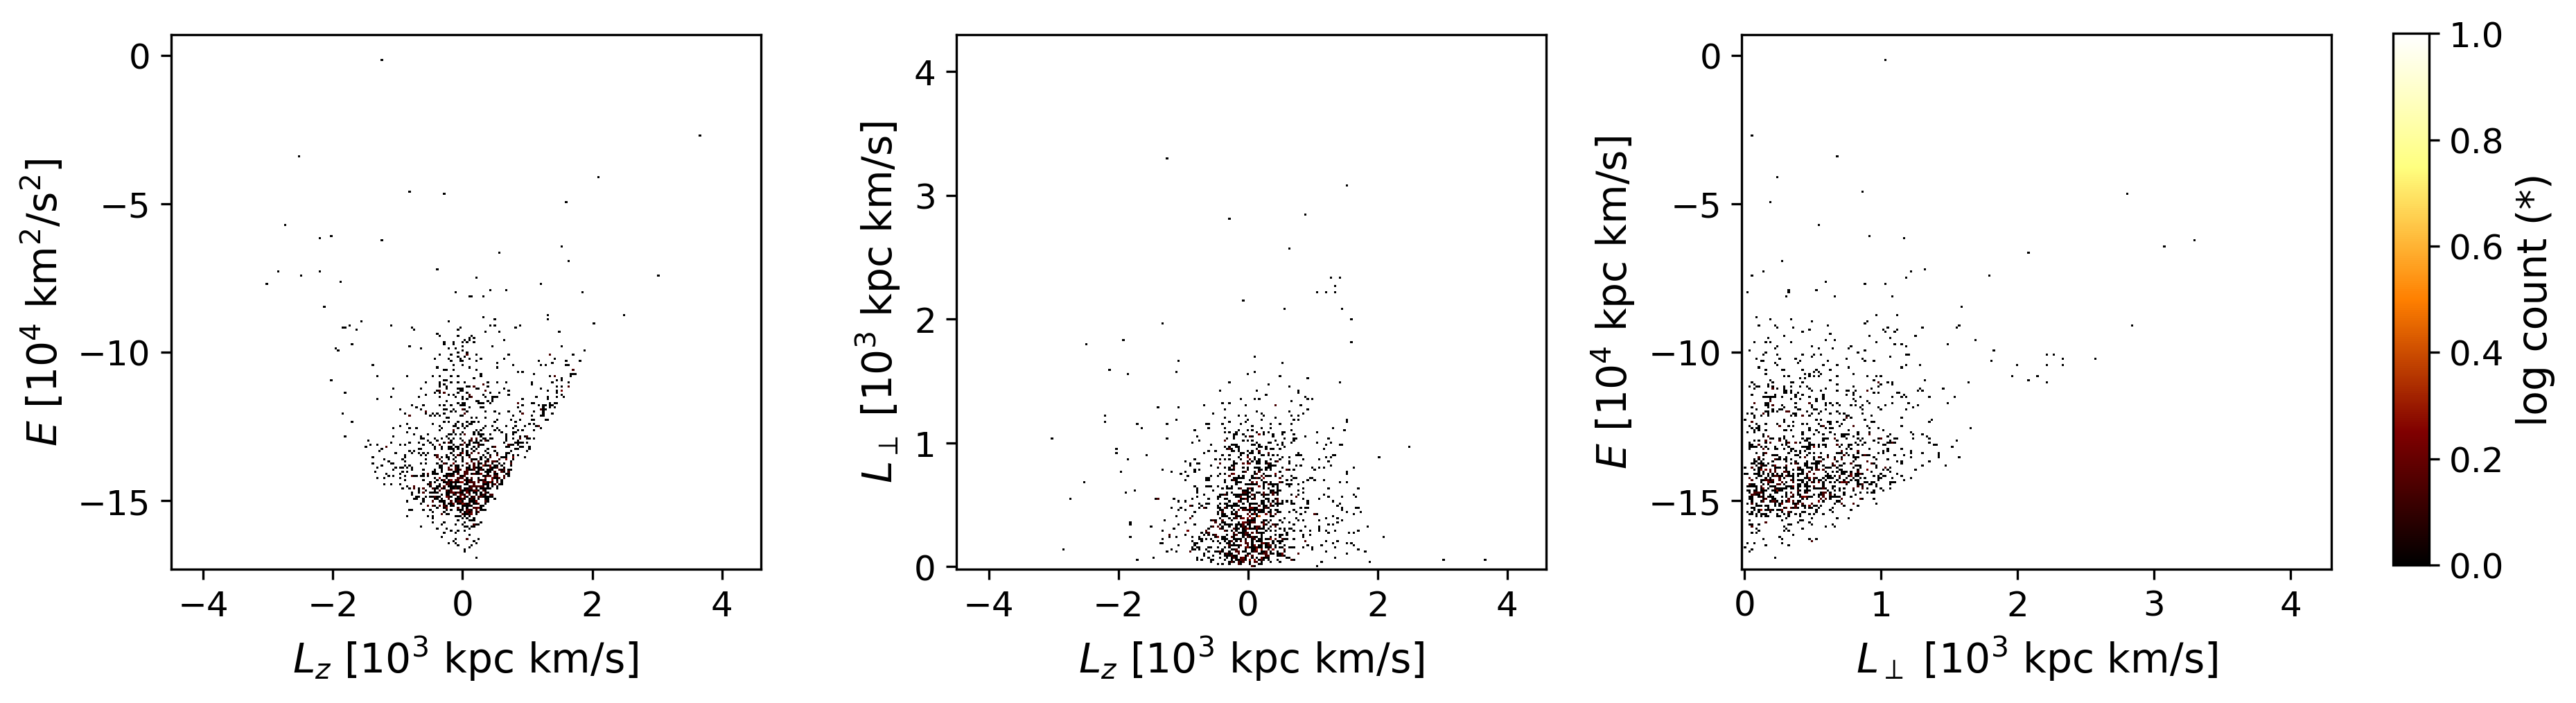

In [52]:
'''Read in data and compute integrals of motion. Input should be a Gaia-style catalogue containing 
heliocentric xyz coordinates and xyz velocity components (for recommended quality cuts, see paper).
Should contain at least halo stars and a little bit extra, as we use vtoomre>180 for generating 
the artificial reference halos.'''

ds = vaex.open(catalogue_path)
ds = importdata.get_GAIA(ds)

print(f'Original catalogue count: {ds.count()}')

'''Extract halo stars'''
df = ds[ds.vtoomre > 210]
df.export_hdf5(f'{result_path}df.hdf5')

print(f'Halo set count: {df.count()}')

'''Plot clustering subspaces'''
plotting_utils.plot_original_data_3D(df)

INFO:MainThread:matplotlib.mathtext:Substituting symbol \perp from STIXGeneral
INFO:MainThread:matplotlib.mathtext:Substituting symbol \perp from STIXGeneral
INFO:MainThread:matplotlib.mathtext:Substituting symbol \perp from STIXGeneral
INFO:MainThread:matplotlib.mathtext:Substituting symbol \perp from STIXGeneral
INFO:MainThread:matplotlib.mathtext:Substituting symbol \perp from STIXGeneral
INFO:MainThread:matplotlib.mathtext:Substituting symbol \perp from STIXGeneral


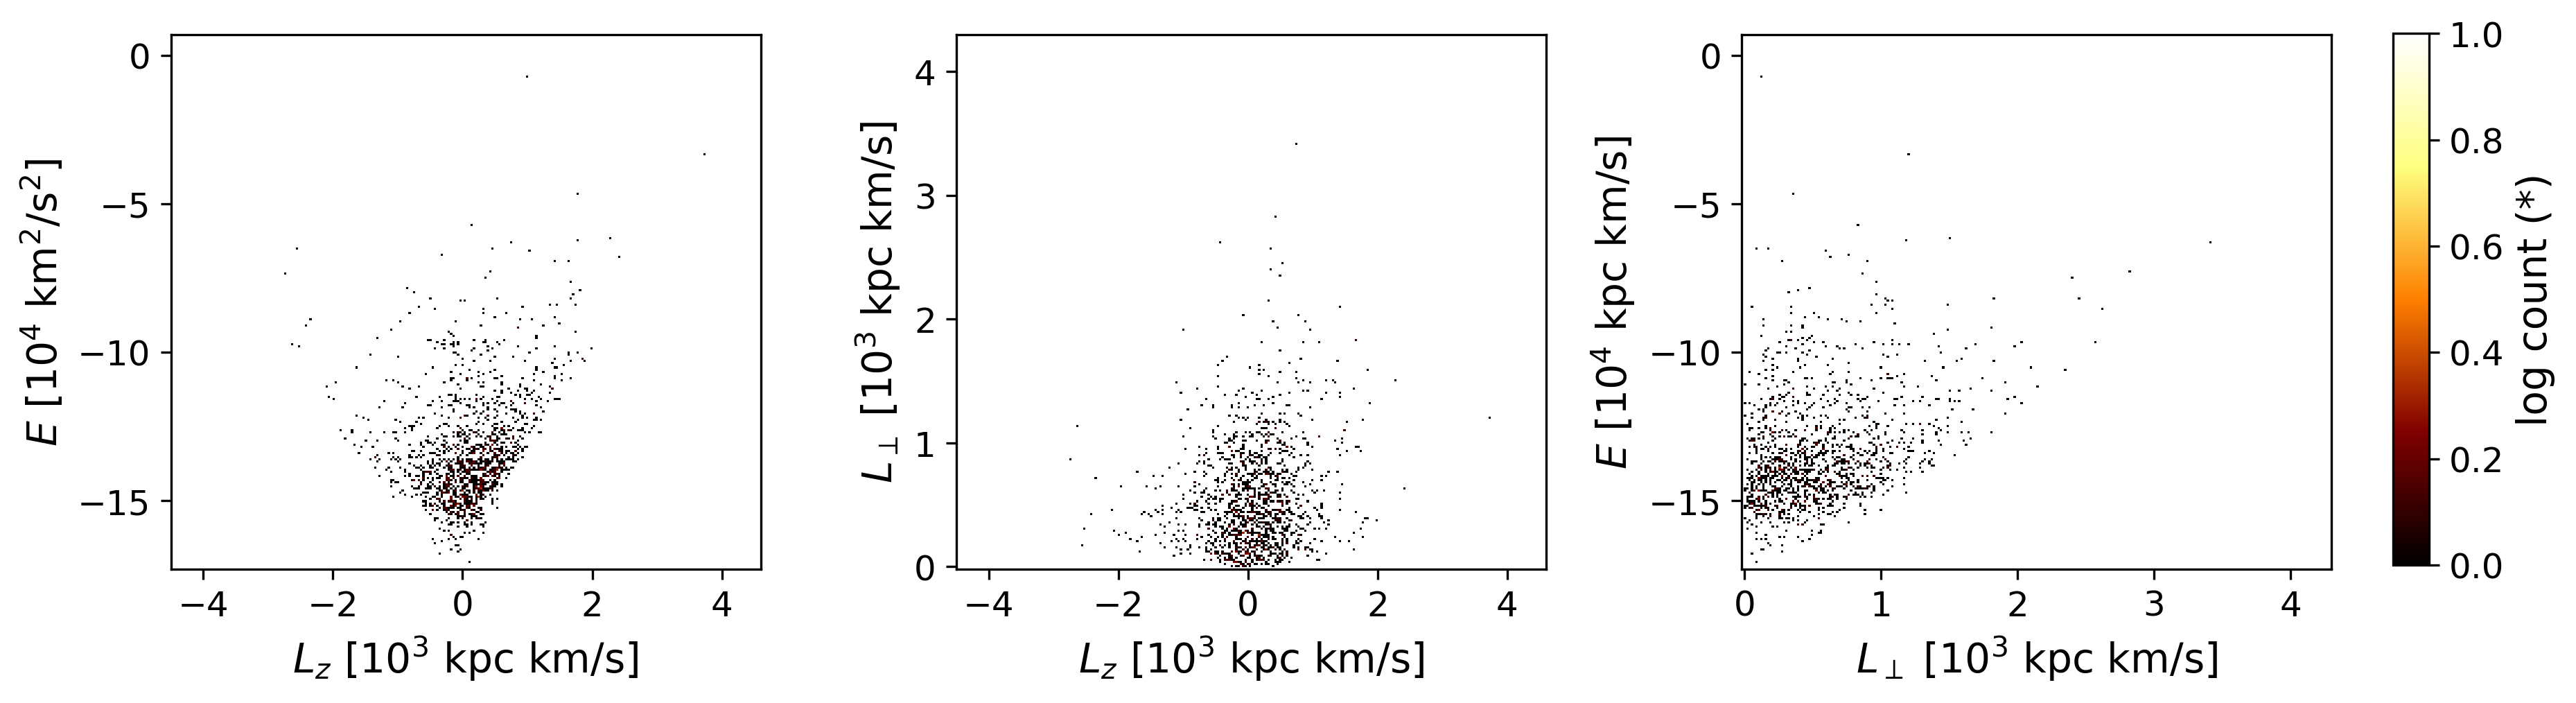

In [53]:
'''Generate artificial halos by scrambling the velocity components of the existing data and recomputing the integrals of motion.
This artificial halo is used to assess overdensities we find in the real data'''

df_vtoomre180 = ds[ds.vtoomre > 180]

df_artificial = cluster_utils.get_artificial_set(N_datasets, df_vtoomre180)
df_artificial = cluster_utils.scaleData(df_artificial, features_to_be_scaled, minmax_values)
df_artificial.export_hdf5(f'{result_path}df_artificial.hdf5')

plotting_utils.plot_original_data_3D(df_artificial[df_artificial.index==2])

In [3]:
'''Apply single linkage and prepare for analysis of merging hierarchy'''

df = vaex.open(f'{result_path}df.hdf5')
df = cluster_utils.scaleData(df, features_to_be_scaled, minmax_values)
df_artificial = vaex.open(f'{result_path}df_artificial.hdf5')
df_artificial = cluster_utils.scaleData(df_artificial, features_to_be_scaled, minmax_values)
Z = cluster_utils.clusterData(df, features, linkage_method)
stats = vaex.from_arrays(index1=Z[:,0], index2=Z[:,1], members=Z[:,3], i=range(len(Z)))

In [11]:
art_region_count, art_region_count_std, real_region_count = cluster_utils.count_stars(df, df_artificial, stats, Z)

#Insert the computation of expected count into the dataframe holding information about each candidate cluster
stats['region_counts'] = art_region_count
stats['region_count_stds'] = art_region_count_std
stats['within_ellipse_count'] = real_region_count

#Derived column: Computing the statistical significance
stats['significance'] = (stats['within_ellipse_count']-stats['region_counts']) / \
                         np.sqrt(stats['within_ellipse_count'] + np.power(stats['region_count_stds'], 2))

  0%|          | 0/1369 [00:00<?, ?it/s]

<ipython-input-10-6c7ef5893d93>:57: RuntimeWarning: invalid value encountered in sqrt
  r2 = n_std*np.sqrt(pca.eigen_values_[2])
<ipython-input-10-6c7ef5893d93>:56: RuntimeWarning: invalid value encountered in sqrt
  r1 = n_std*np.sqrt(pca.eigen_values_[1])


Picking out the clusters with maximum significance from the tree...


<string>:1: RuntimeWarning: invalid value encountered in true_divide


  0%|          | 0/75 [00:00<?, ?it/s]

Extracting labels...


  0%|          | 0/25 [00:00<?, ?it/s]

Number of clusters: 25


INFO:MainThread:matplotlib.mathtext:Substituting symbol \perp from STIXGeneral
INFO:MainThread:matplotlib.mathtext:Substituting symbol \perp from STIXGeneral
INFO:MainThread:matplotlib.mathtext:Substituting symbol \perp from STIXGeneral
INFO:MainThread:matplotlib.mathtext:Substituting symbol \perp from STIXGeneral
INFO:MainThread:matplotlib.mathtext:Substituting symbol \perp from STIXGeneral
INFO:MainThread:matplotlib.mathtext:Substituting symbol \perp from STIXGeneral


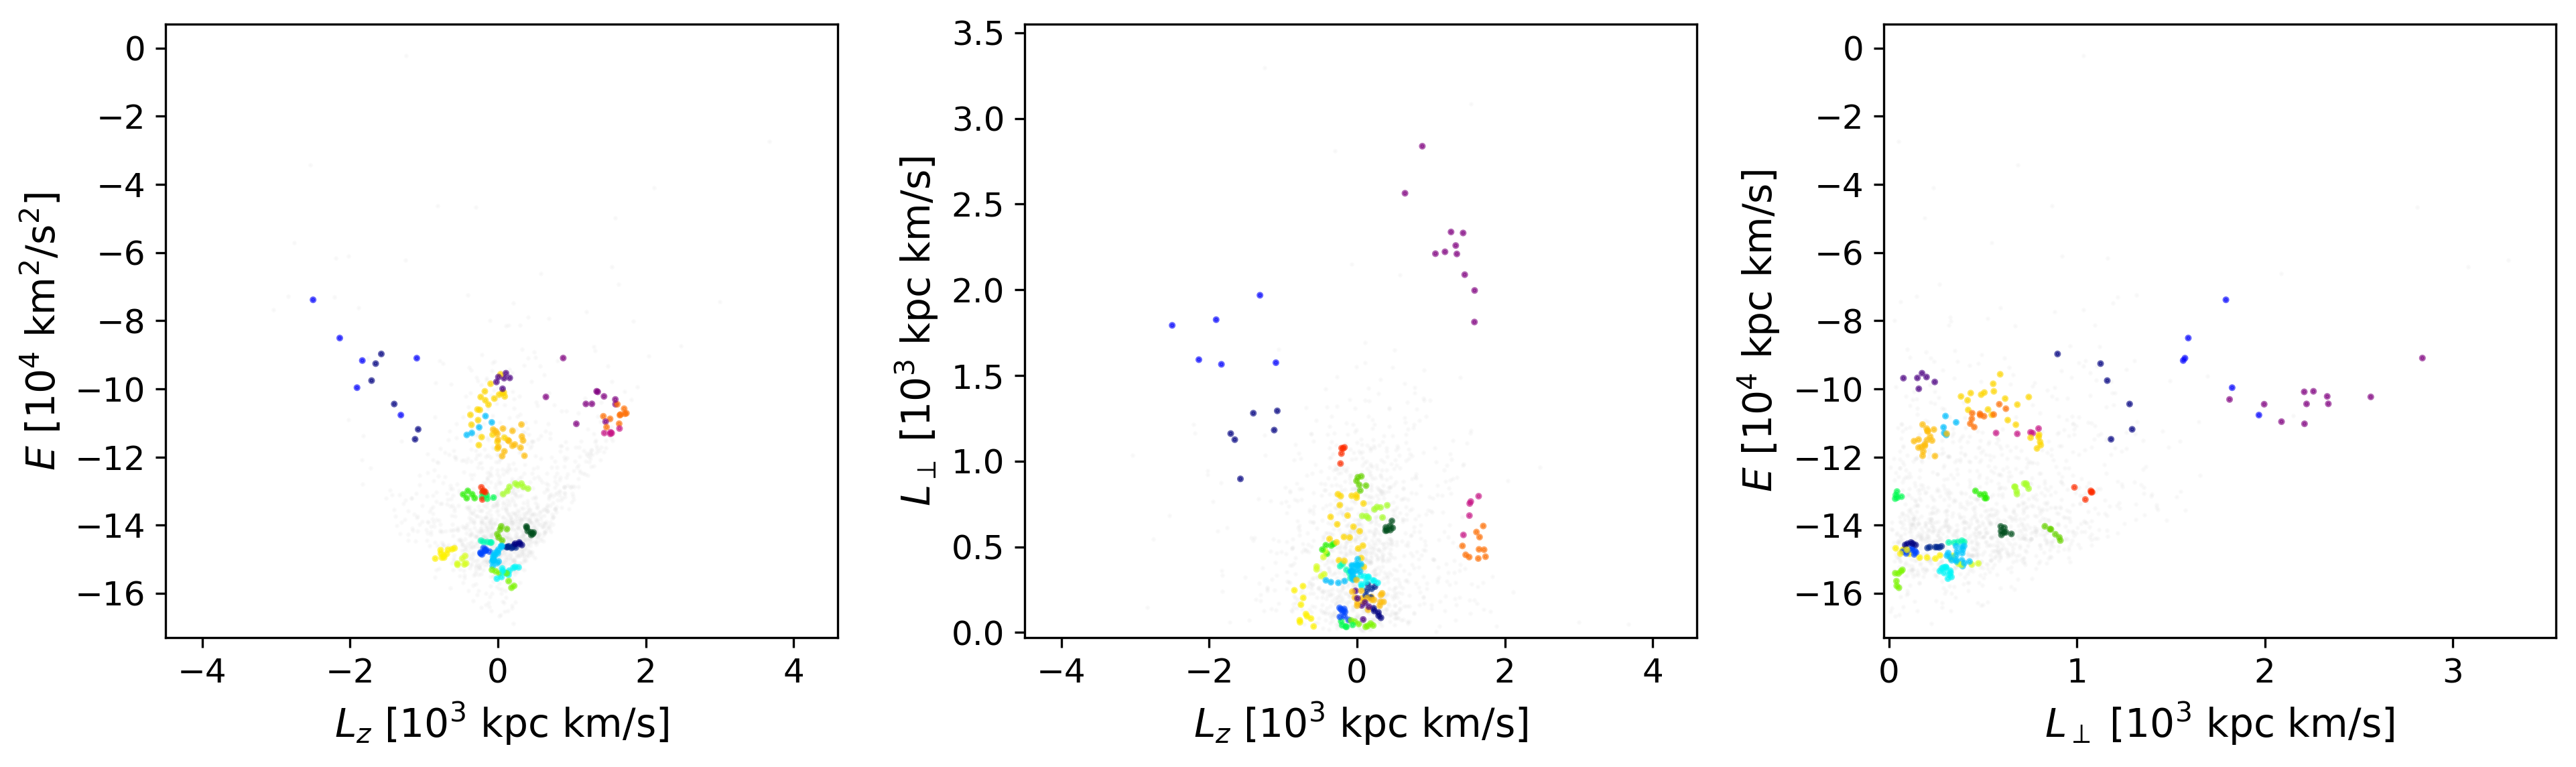

In [54]:
'''Select all clusters that satisfy your chosen minimum statistical significance level.
To distinguish between hierarchically overlapping significant clusters when extracting the final 
cluster labels, select the cluster which displays the maximum statistical significance.'''

selected, statistical_significance = cluster_utils.select_maxsig_clusters_from_tree(stats,
                                     minimum_significance = N_sigma_significance)

maxsigclusters = stats.take(selected)
labels, significance_list = cluster_utils.get_cluster_labels_with_significance(maxsigclusters, Z)
df['labels'] = labels.astype(int)
df['significance'] = significance_list

plotting_utils.plot_IOM_subspaces_3D(df, minsig = N_sigma_significance, savepath=None)

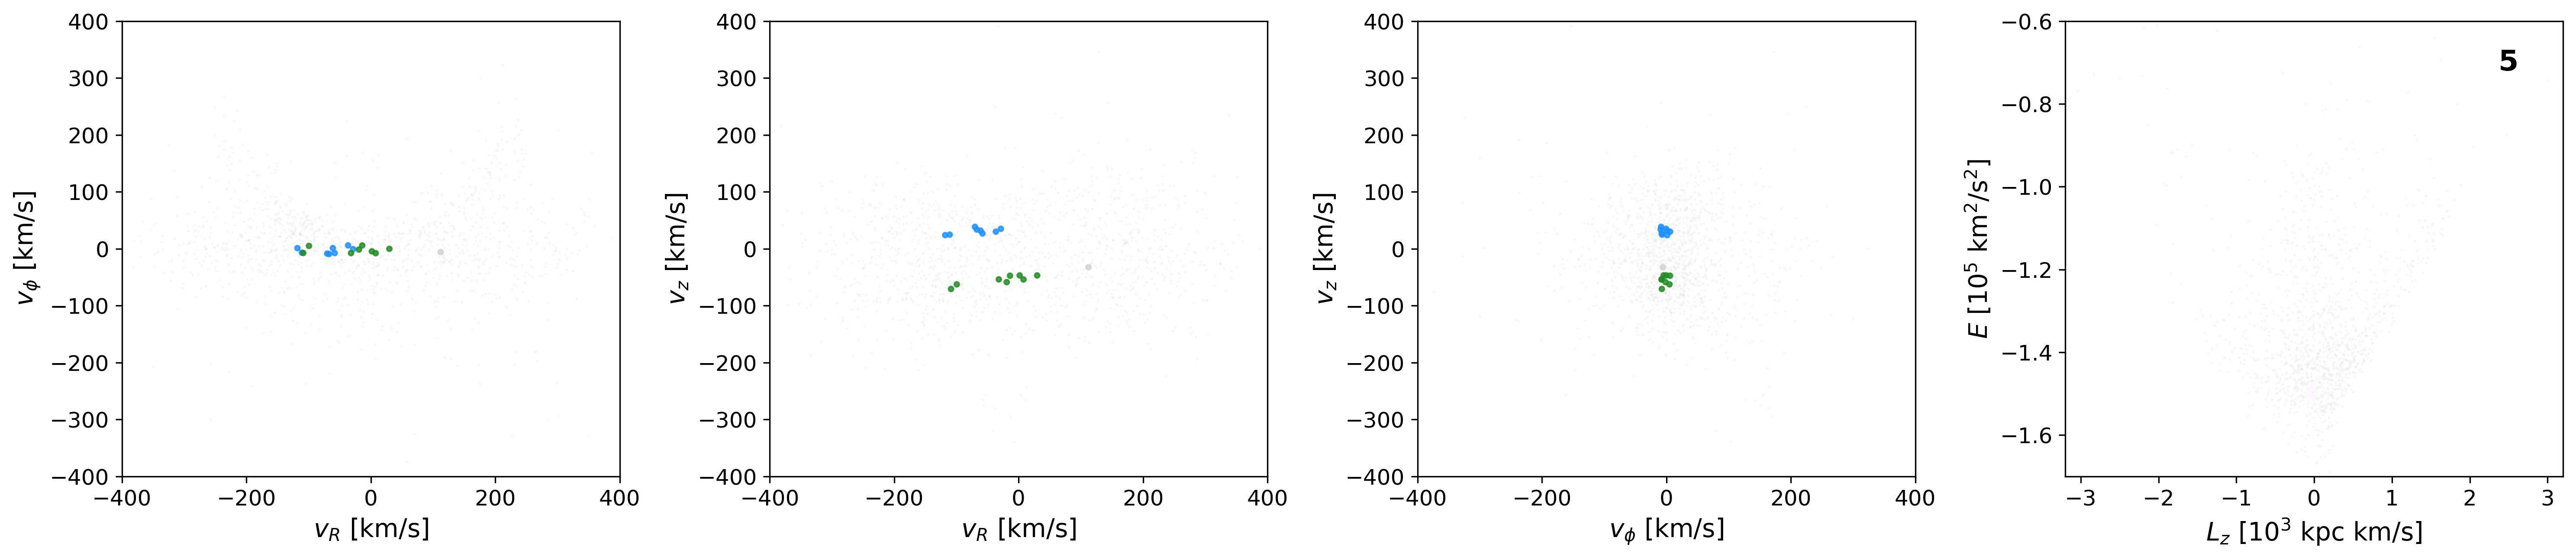

In [46]:
'''Add labels for subgroup membership in velocity space. Requires having the hdbscan library installed.'''

import velocity_space
reload(velocity_space)

if('vR' not in df.get_column_names()):
    df = importdata.get_GAIA(df) #in case the polar coordinate velocities are missing, re-run it trough the get_gaia function
    
df = velocity_space.apply_HDBSCAN_vspace(df)

#Plot an example: The subgroups for cluster nr 5
plotting_utils.plot_subgroup_vspace_En_Lz(df, clusterNr = 5)

In [ ]:
'''Export result catalogue'''

df.export_hdf5(f'{result_path}df_labels.hdf5')